# Monte Carlo Simulation with Correlated Geometric Brownian Motion

We model the stock prices of multiple assets under the **Geometric Brownian Motion (GBM)** framework.

---

## 1. Returns and Parameters

For asset $ i $, let the price series be $ S_{i,t} $.  
The **log return** is

$
r_{i,t} = \ln \left( \frac{S_{i,t}}{S_{i,t-1}} \right)
$

We estimate:

- Mean return:
$
\mu_i = \frac{1}{T-1} \sum_{t=1}^{T-1} r_{i,t}
$

- Volatility:
$
\sigma_i = \sqrt{\frac{1}{T-2} \sum_{t=1}^{T-1} (r_{i,t} - \mu_i)^2}
$

Stacked into vectors:

$
\boldsymbol{\mu} =
\begin{bmatrix}
\mu_1 \\ \mu_2 \\ \vdots \\ \mu_n
\end{bmatrix},
\quad
\boldsymbol{\sigma} =
\begin{bmatrix}
\sigma_1 \\ \sigma_2 \\ \vdots \\ \sigma_n
\end{bmatrix}
$

---

## 2. Correlation and Cholesky

Construct the sample **correlation matrix** of returns:

$
\mathbf{C} = \big[ \rho_{ij} \big]_{i,j=1}^n
$

where

$
\rho_{ij} = \frac{\text{Cov}(r_i, r_j)}{\sigma_i \sigma_j}
$

Then compute the **Cholesky decomposition**:

$
\mathbf{C} = \mathbf{L} \mathbf{L}^\top
$

with $\mathbf{L}$ lower-triangular.

---

## 3. Simulated Brownian Increments

Generate i.i.d. standard normal vectors:

$
\mathbf{Z}_t \sim \mathcal{N}(0, \mathbf{I}_n), \quad t = 1, \dots, T
$

Apply correlation structure:

$
\mathbf{W}_t = \mathbf{L} \mathbf{Z}_t
$

Thus, $\mathbf{W}_t \sim \mathcal{N}(0, \mathbf{C})$.

---

## 4. Geometric Brownian Motion (GBM)

For each asset $ i $:

$
S_{i,t} = S_{i,0} \cdot \exp \Bigg( \Big(\mu_i - \tfrac{1}{2}\sigma_i^2\Big)t \;+\; \sigma_i W_{i,t} \Bigg)
$

In vector form:

$
\mathbf{S}_t = \mathbf{S}_0 \odot \exp \Bigg( 
\big(\boldsymbol{\mu} - \tfrac{1}{2}\boldsymbol{\sigma}^2\big) t \;+\; \boldsymbol{\sigma} \odot \mathbf{W}_t
\Bigg)
$

where:
- $ \odot $ denotes elementwise multiplication,
- $ \boldsymbol{\sigma}^2 = (\sigma_1^2, \dots, \sigma_n^2)^\top $,
- $ \exp $ is applied elementwise.

---

## 5. Monte Carlo Replications

Repeat the above for $ N $ independent simulations:

$
\mathbf{S}_t^{(k)}, \quad k = 1, \dots, N
$

This yields a **3D object**:

$
\text{Simulations: } \quad \mathbb{R}^{N \times T \times n}
$

- $ N $: number of paths  
- $ T $: time steps  
- $ n $: number of assets  

---


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm


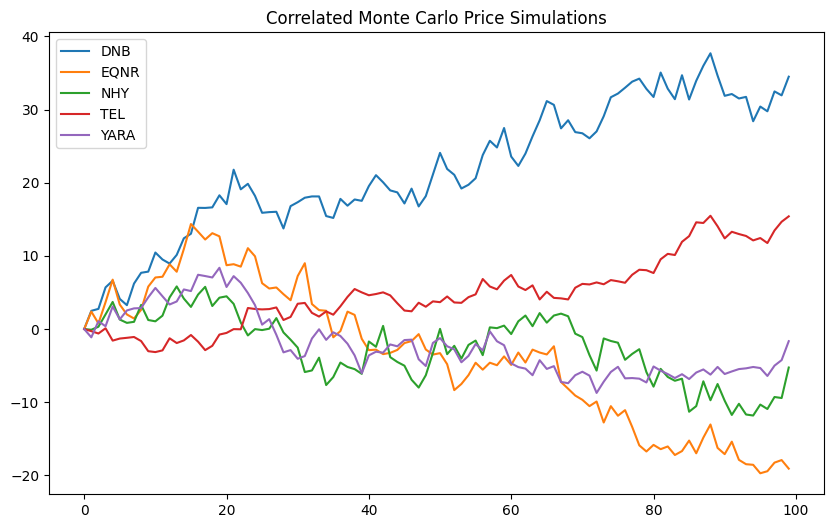

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
T = 100     # time steps
N = 50      # number of simulations per stock

# --- Load dataset ---
df = pd.read_csv("OSEBX_Q1Q2_with_indicators.csv", sep=";")

# --- Unique tickers ---
tickers = df["Ticker"].unique()
n_assets = len(tickers)

# --- Estimate parameters ---
mu_dict, sigma_dict = {}, {}
returns_df = pd.DataFrame()

for ticker in tickers:
    df_t = df[df["Ticker"] == ticker].reset_index(drop=True)
    S = df_t['Close'].astype(float)
    
    # returns
    S_lag = S[:-1].reset_index(drop=True)
    S_curr = S[1:].reset_index(drop=True)
    dS = np.array(S_curr) / np.array(S_lag) - 1
    
    # store mean and vol
    mu_dict[ticker] = np.mean(dS)
    sigma_dict[ticker] = np.std(dS, ddof=1)
    
    # collect returns for correlation
    returns_df[ticker] = dS

# --- Correlation & Cholesky ---
corr = returns_df.corr().values
L = np.linalg.cholesky(corr)   # lower triangular

# --- Monte Carlo simulations with correlation ---
simulations = {}

for t_idx, ticker in enumerate(tickers):
    S0 = df[df["Ticker"] == ticker]['Close'].iloc[0]
    simulations[ticker] = np.zeros((N, T))
    simulations[ticker][:, 0] = S0

# simulate paths jointly
for i in range(N):
    # correlated random shocks for all assets
    Z = np.random.normal(size=(T-1, n_assets))
    correlated_Z = np.inner(Z, L.T)  # apply Cholesky
    
    for t in range(1, T):
        for j, ticker in enumerate(tickers):
            mu = mu_dict[ticker]
            sigma = sigma_dict[ticker]
            S0 = simulations[ticker][i, t-1]
            
            drift = (mu - 0.5 * sigma**2)*dt
            shock = sigma * correlated_Z[t-1, j]
            
            simulations[ticker][i, t] = S0 * np.exp(drift + shock)

# --- Plot example paths ---
plt.figure(figsize=(10,6))
for ticker in tickers:
    plt.plot(range(T), 100*(simulations[ticker][0]/simulations[ticker][0][0] - 1), label=ticker)  # first path of each stock
plt.legend()
plt.title("Correlated Monte Carlo Price Simulations")
plt.show()


# Portfolio Optimization Based on Simulated μ/σ Ratios

We use Monte Carlo simulations of stock prices to inform a simple **risk-adjusted selection strategy**.

---

## 1. Simulated Price Paths

Each stock $i$ has a set of Monte Carlo simulations $S_{i,t}^{(k)}$ for time steps $t = 0, \dots, T-1$ and simulation rounds $k = 1, \dots, N$:

$
S_{i,t}^{(k)} = S_{i,0} \exp \Big( (\mu_i - \tfrac{1}{2}\sigma_i^2) t + \sigma_i W_{i,t}^{(k)} \Big)
$

where:
- $\mu_i$ is the estimated daily drift of stock $i$,
- $\sigma_i$ is the estimated daily volatility of stock $i$,
- $W_{i,t}^{(k)}$ is the Brownian motion (or cumulative normal shocks) for simulation $k$.

---

## 2. Pathwise Returns

For each simulation $k$ and stock $i$, compute discrete returns along the simulated path:

$
r_{i,t}^{(k)} = \frac{S_{i,t}^{(k)} - S_{i,t-1}^{(k)}}{S_{i,t-1}^{(k)}}, \quad t = 1, \dots, T-1
$

Then compute the **mean** and **standard deviation** of returns for this path:

$
\hat{\mu}_i^{(k)} = \frac{1}{T-1} \sum_{t=1}^{T-1} r_{i,t}^{(k)}, 
\quad
\hat{\sigma}_i^{(k)} = \sqrt{ \frac{1}{T-2} \sum_{t=1}^{T-1} \big(r_{i,t}^{(k)} - \hat{\mu}_i^{(k)}\big)^2 }
$

---

## 3. Risk-Adjusted Performance Metric

Define the **risk-adjusted ratio** for each stock in each simulation:

$
R_i^{(k)} = \frac{\hat{\mu}_i^{(k)}}{\hat{\sigma}_i^{(k)}}
$

This is essentially a **Sharpe-like ratio** without subtracting the risk-free rate.

---

## 4. Optimal Stock Selection Per Simulation

For each Monte Carlo round $k$, select the stock with the highest risk-adjusted ratio:

$
i^*_{(k)} = \arg \max_i R_i^{(k)}
$

Count how often each stock is selected across all $N$ simulations:

$
f_i = \frac{1}{N} \sum_{k=1}^{N} \mathbf{1}\{ i^*_{(k)} = i \}
$

where $\mathbf{1}\{\cdot\}$ is the indicator function.

---

## 5. Portfolio Composition

The vector of frequencies

$
\mathbf{f} = [f_1, f_2, \dots, f_n]
$

represents a **simple optimal portfolio composition**:

- Each component $f_i$ is the proportion of simulations in which stock $i$ was the best risk-adjusted performer.
- The sum of all components is 1:

$
\sum_{i=1}^{n} f_i = 1
$

This can be visualized as a **pie chart** or bar chart showing relative preference for each stock.

---

### Summary

- Step 1: Simulate correlated or independent price paths for each stock.  
- Step 2: Compute pathwise returns and their mean/volatility.  
- Step 3: Calculate risk-adjusted ratios ($\mu/\sigma$) for each simulation.  
- Step 4: Pick the best-performing stock per simulation.  
- Step 5: Aggregate counts to construct a simple **probability-weighted portfolio**.


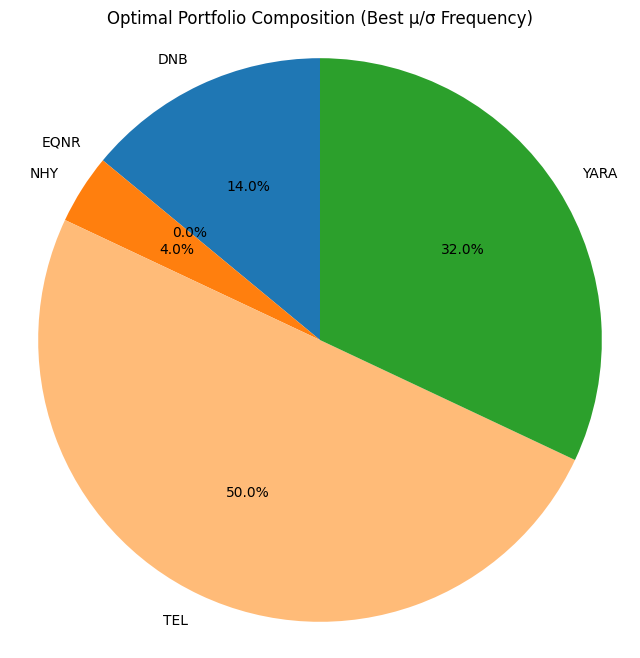

In [15]:
best_counts = {ticker: 0 for ticker in tickers}

for sim_round in range(N):
    ratios = {}
    for ticker in tickers:
        path = simulations[ticker][sim_round]
        
        # compute returns for this path
        returns = np.diff(path) / path[:-1]
        mu_path = np.mean(returns)
        sigma_path = np.std(returns, ddof=1)
        
        # avoid division by zero
        if sigma_path > 0:
            ratios[ticker] = mu_path / sigma_path
        else:
            ratios[ticker] = -np.inf
    
    # pick best ticker
    best_ticker = max(ratios, key=ratios.get)
    best_counts[best_ticker] += 1

# --- Convert results to portfolio composition ---
portfolio = pd.Series(best_counts) / N

# --- Plot composition as pie chart ---
plt.figure(figsize=(8,8))
plt.pie(portfolio, labels=portfolio.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)
plt.title("Optimal Portfolio Composition (Best μ/σ Frequency)")
plt.axis('equal')  # ensures pie is circular
plt.show()